In [1]:
%pylab inline
import pandas as pd
import xarray as xr
from pyproj import Transformer

import plotly.express as px

#if you do not see any plots, you might need to define the renderer:
#import plotly.io as pio
#pio.renderers.default='iframe' #for windows use 'notebook' instead


Populating the interactive namespace from numpy and matplotlib


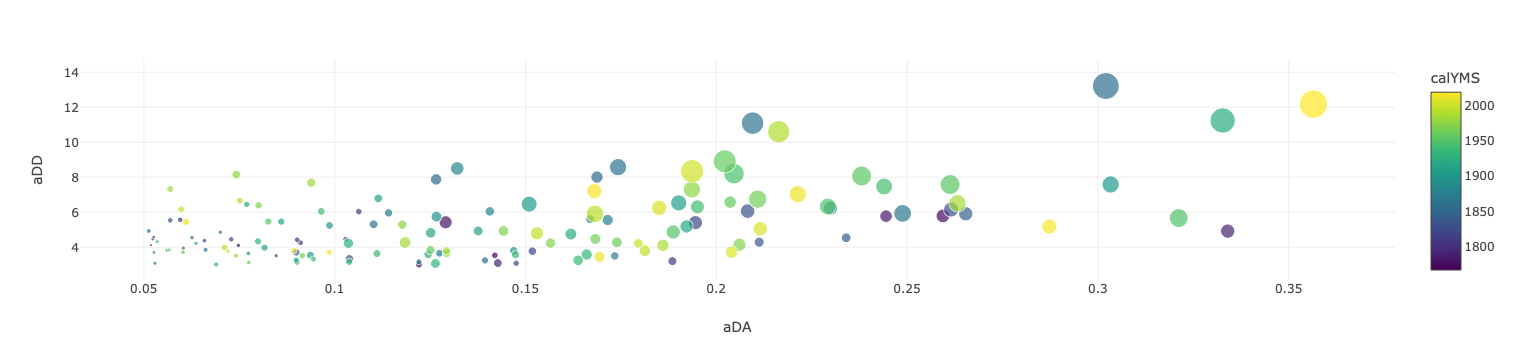

In [100]:
# plot prepared data

# aDD = average Drought Duration
# aDA = average Drought Area
# TDM = total drought magnitude
# calYMS = year start

ADMx = pd.read_csv('./observation_based/results_ADM_yyyymm.txt',delim_whitespace=True,index_col=0)
px.scatter(ADMx, x='aDA', y='aDD',size='TDM', color='calYMS', template='none')

In [ ]:
# same plot but with self-made year column
# aDD = average Drought Duration
# aDA = average Drought Area
# TDM = total drought magnitude

ADM = pd.read_csv('./observation_based/results_ADM.txt',delim_whitespace=True,index_col=0)

ADM.mstartx = pd.to_datetime('1766-01-01') 
for i in ADM.index:
    ADM.loc[i,'mstartx'] = pd.to_datetime('1766-01-01') + pd.DateOffset(months=ADM.loc[i,'mStart'])
    
ADM['mstarty'] = pd.to_datetime(ADM['mstartx'].values).year

px.scatter(ADM, x='aDA', y='aDD',size='TDM', color='mstarty', template='none')

In [ ]:
# NOW WE GO TO NetCDF DATA

In [43]:
smi = xr.open_dataset('./observation_based/SMI_v2.nc')
smic = xr.open_dataset('./observation_based/SMIc_v2.nc')

/Users/cojack/miniconda3/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning:

variable 'lat' has multiple fill values {-9999.0, '-9999.000000'}, decoding all values to NaN.

/Users/cojack/miniconda3/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning:

variable 'lon' has multiple fill values {-9999.0, '-9999.000000'}, decoding all values to NaN.



In [44]:
# show xarray (netcdf data)
smic

/Users/cojack/miniconda3/lib/python3.7/site-packages/xarray/coding/variables.py:141: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



<xarray.Dataset>
Dimensions:  (time: 3048, xc: 100, yc: 95)
Coordinates:
  * time     (time) datetime64[ns] 1766-01-31 1766-02-28 ... 2019-12-31
  * xc       (xc) float32 2.525e+06 2.575e+06 2.625e+06 ... 7.425e+06 7.475e+06
  * yc       (yc) float32 5.475e+06 5.425e+06 5.375e+06 ... 8.25e+05 7.75e+05
Data variables:
    mSMIc    (time, yc, xc) float32 ...
    lat      (yc, xc) float32 ...
    lon      (yc, xc) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Thu Jul 07 19:32:50 2022: cdo -f nc4c -z zip_4 -b F32 copy ...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

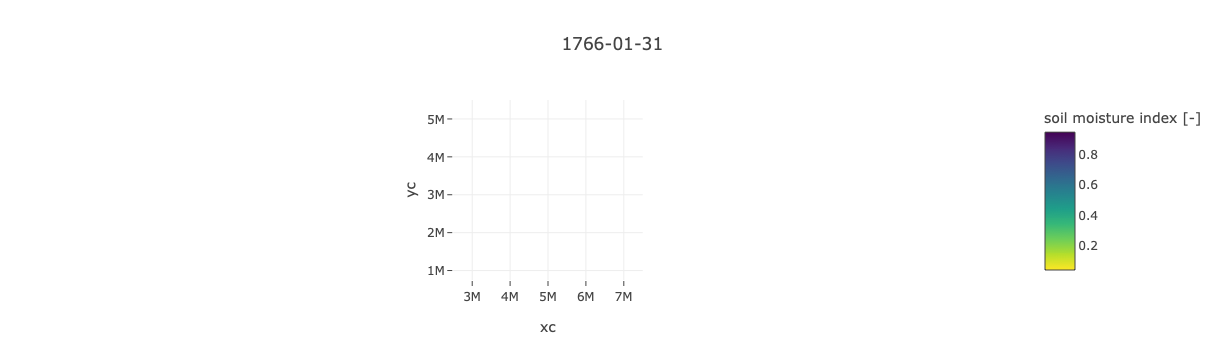

In [55]:
# direct plot of first time entry (0) -- you can change the index i as you like
i=0
px.imshow(smi.SMI[i],x=smi.xc,y=smi.yc, origin='lower', aspect='equal', template='none', color_continuous_scale='viridis_r', title=str(pd.to_datetime(smi.time[i].values).date()))

In [101]:
px.set_mapbox_access_token('pk.eyJ1IjoiY29qYWNrIiwiYSI6IkRTNjV1T2MifQ.EWzL4Qk-VvQoaeJBfE6VSA')
#take smi to a dataframe
smidf = smi.to_dataframe()

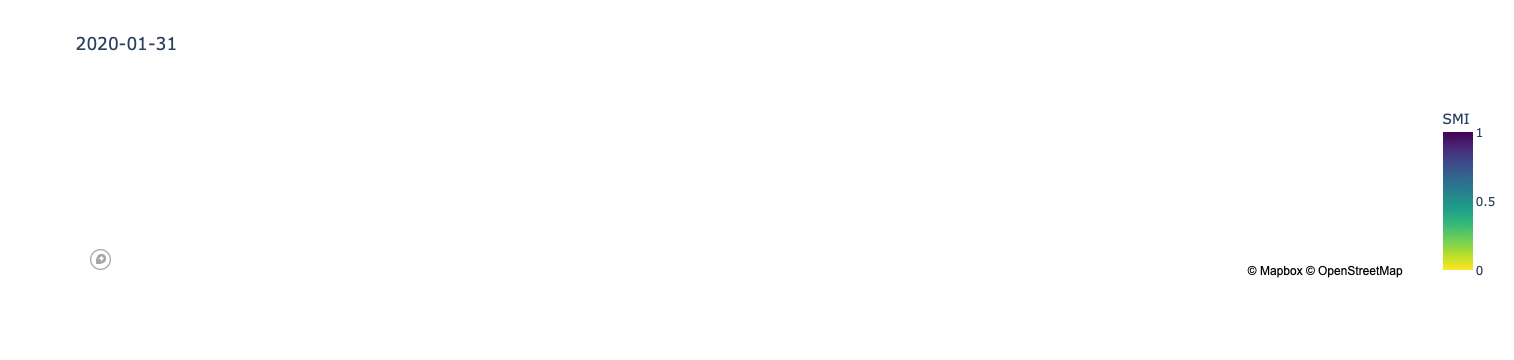

In [102]:
# nice plot with map
i = -10
fig = px.scatter_mapbox(smidf.loc[pd.to_datetime(smi.time[i].values)].dropna(), lat='lat', lon='lon',  color='SMI', title=str(pd.to_datetime(smi.time[-10].values).date()),color_continuous_scale='viridis_r',range_color=(0.,1.), zoom=2)
fig.show()

In [ ]:
#eobs: https://surfobs.climate.copernicus.eu/dataaccess/access_eobs.php
#cds: https://cds.climate.copernicus.eu/#!/home

In [94]:
pd.to_datetime(smic.time[-10].values)

Timestamp('2019-03-31 00:00:00')

In [63]:
i=-10
(smi.SMI[i].to_dataframe().dropna().SMI<0.2).sum()/2540.

0.2732283464566929

In [65]:
#create your wn drough analysis based on the soil moisture index

drought = pd.DataFrame(index=pd.to_datetime(smi.time), columns=['p20','p10'])
for i in np.arange(len(drought)):
    drought.iloc[i,0] = (smi.SMI[i].to_dataframe().dropna().SMI<0.2).sum()/2540.
    drought.iloc[i,1] = (smi.SMI[i].to_dataframe().dropna().SMI<0.1).sum()/2540.

In [103]:
drought.head()

,p20,p10
1766-01-31,0.101575,0.03189
1766-02-28,0.083858,0.01378
1766-03-31,0.011024,0.000787
1766-04-30,0.079134,0.015748
1766-05-31,0.165748,0.018898


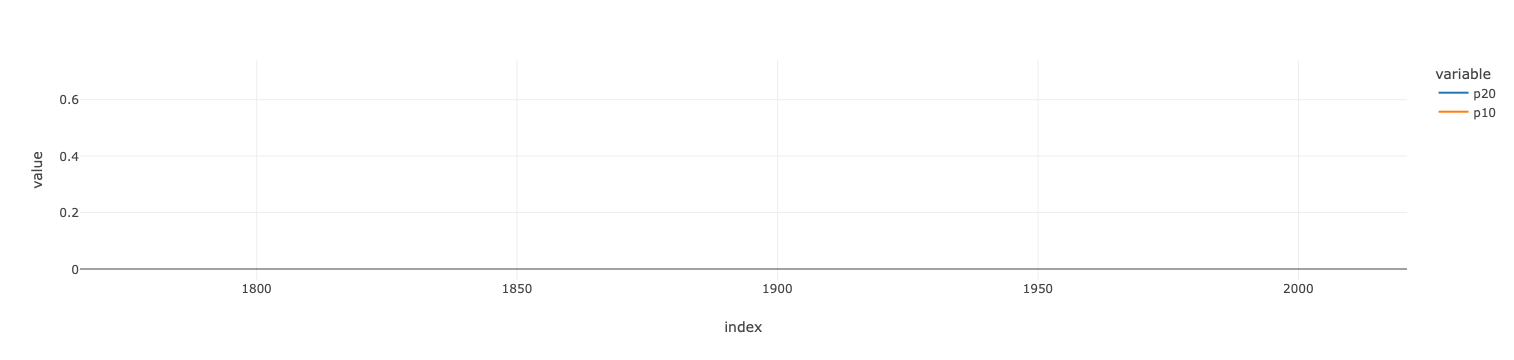

In [113]:
px.line(drought, template='none')

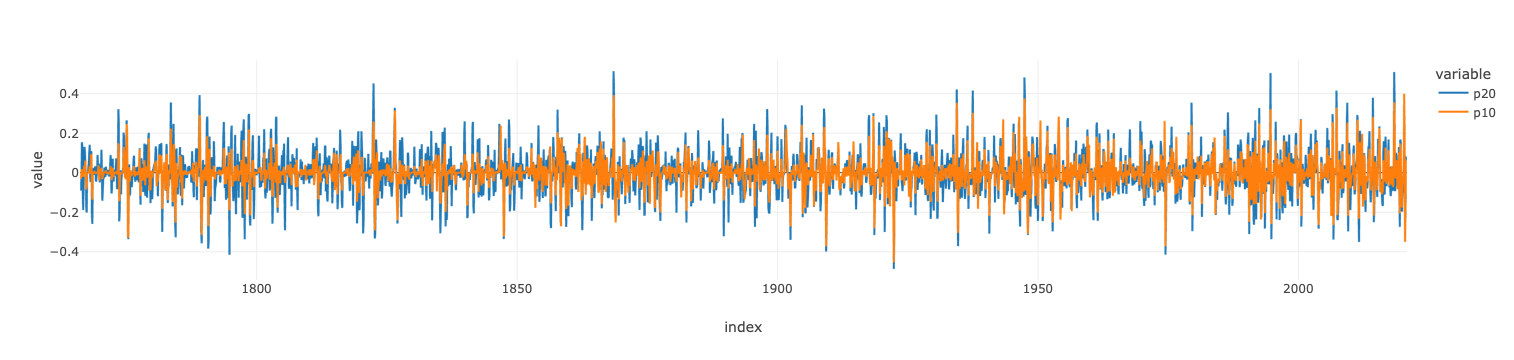

In [69]:
px.line(drought.diff(2), template='none')

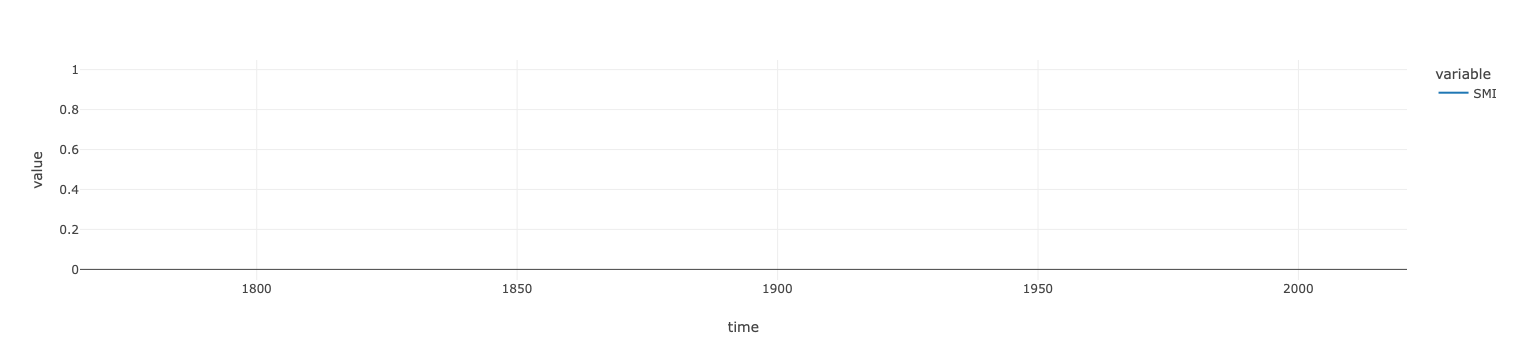

In [76]:
#you can also access the data in the xarray directly -- here for one pixel

xcc = smi.SMI[-50].to_dataframe().dropna().index.get_level_values(0).unique()
ycc = smi.SMI[-50].to_dataframe().dropna().index.get_level_values(1).unique()
#smi.sel(xc=xcc[10],yc=ycc[10]).SMI.plot()#to_dataframe().SMI.plot()
px.line(smi.sel(xc=xcc[10],yc=ycc[10]).to_dataframe().SMI, template='none')

In [104]:
# another try for your own drought analyses

smidy = (smi.SMI<0.2).resample(time="Y").sum()

drought1 = pd.DataFrame(index=pd.to_datetime(smidy.time), columns=['share_any','share_95','length_mean','length_95','length_max'])
for i in np.arange(len(drought1)):
    drought1.iloc[i,0] = (smidy[i].to_dataframe().SMI>0).sum()/2540.
    drought1.iloc[i,1] = (smidy[i].to_dataframe().SMI>smidy[i].to_dataframe().SMI.quantile(0.95)).sum()/2540.
    drought1.iloc[i,2] = smidy[i].to_dataframe().SMI.mean()
    drought1.iloc[i,3] = smidy[i].to_dataframe().SMI.quantile(0.95)
    drought1.iloc[i,4] = smidy[i].to_dataframe().SMI.max()

In [105]:
drought1.head()

,share_any,share_95,length_mean,length_95,length_max
1766-12-31,0.640945,0.153937,0.341474,2.0,10
1767-12-31,0.466535,0.148819,0.280316,2.0,10
1768-12-31,0.416142,0.17126,0.255895,2.0,12
1769-12-31,0.353937,0.162205,0.210632,1.0,12
1770-12-31,0.288189,0.175197,0.201053,1.0,12


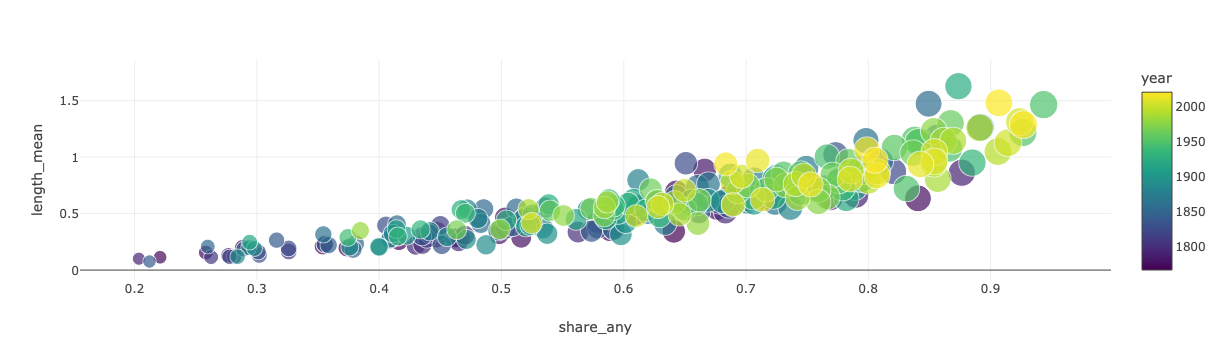

In [86]:
drought1['bubble_size'] = drought1.share_any*0.002
drought1['year'] = drought1.index.year
px.scatter(drought1.astype(float), x='share_any', y='length_mean',size='bubble_size', color='year', template='none')